<a href="https://colab.research.google.com/github/1004516/SE-ALES-Y-SISTEMAS/blob/main/Simulacion_Punto%201%2C5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

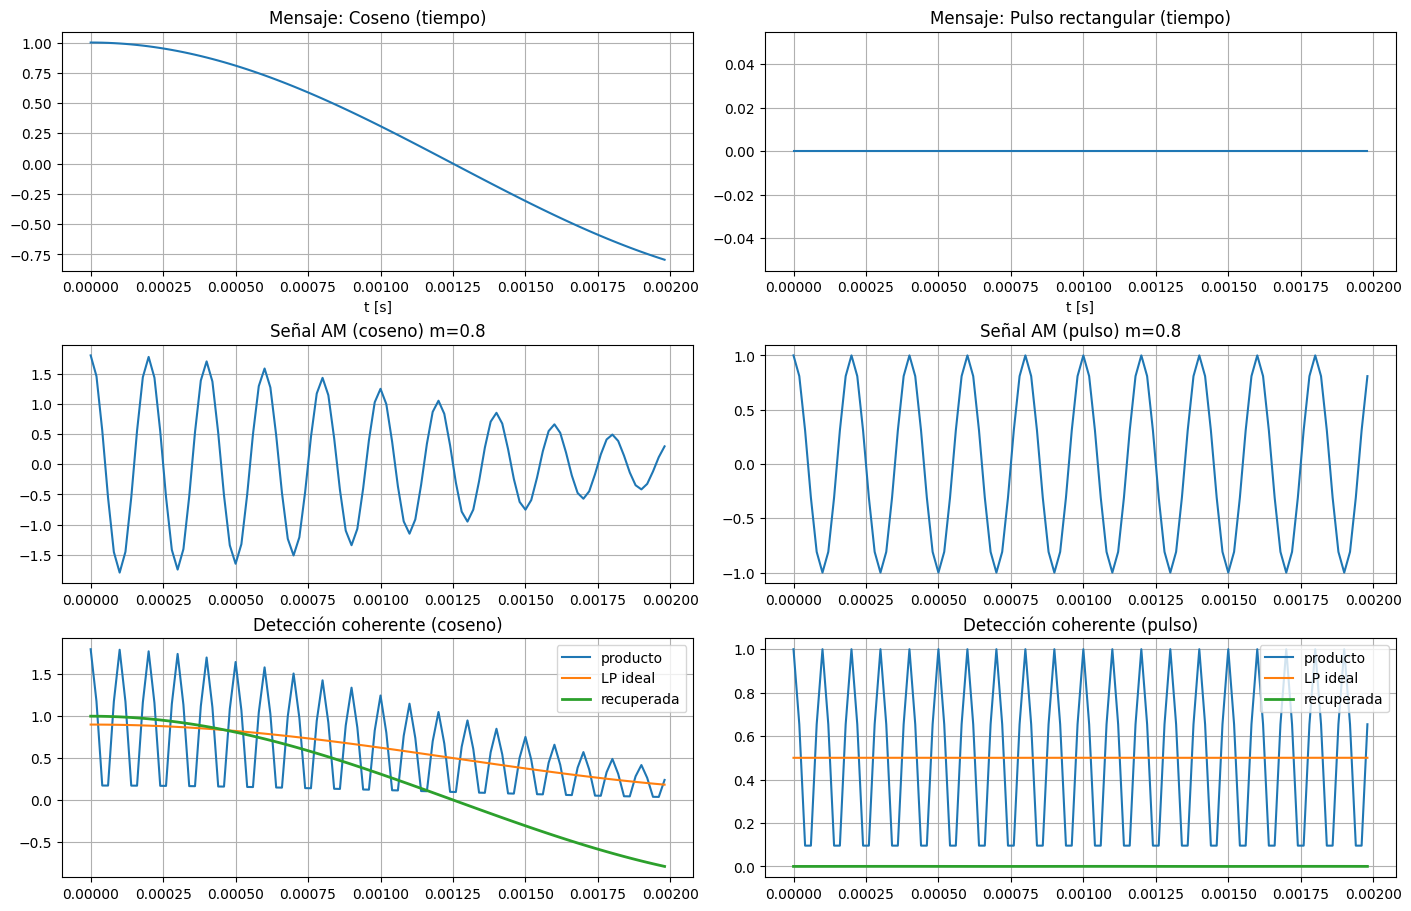

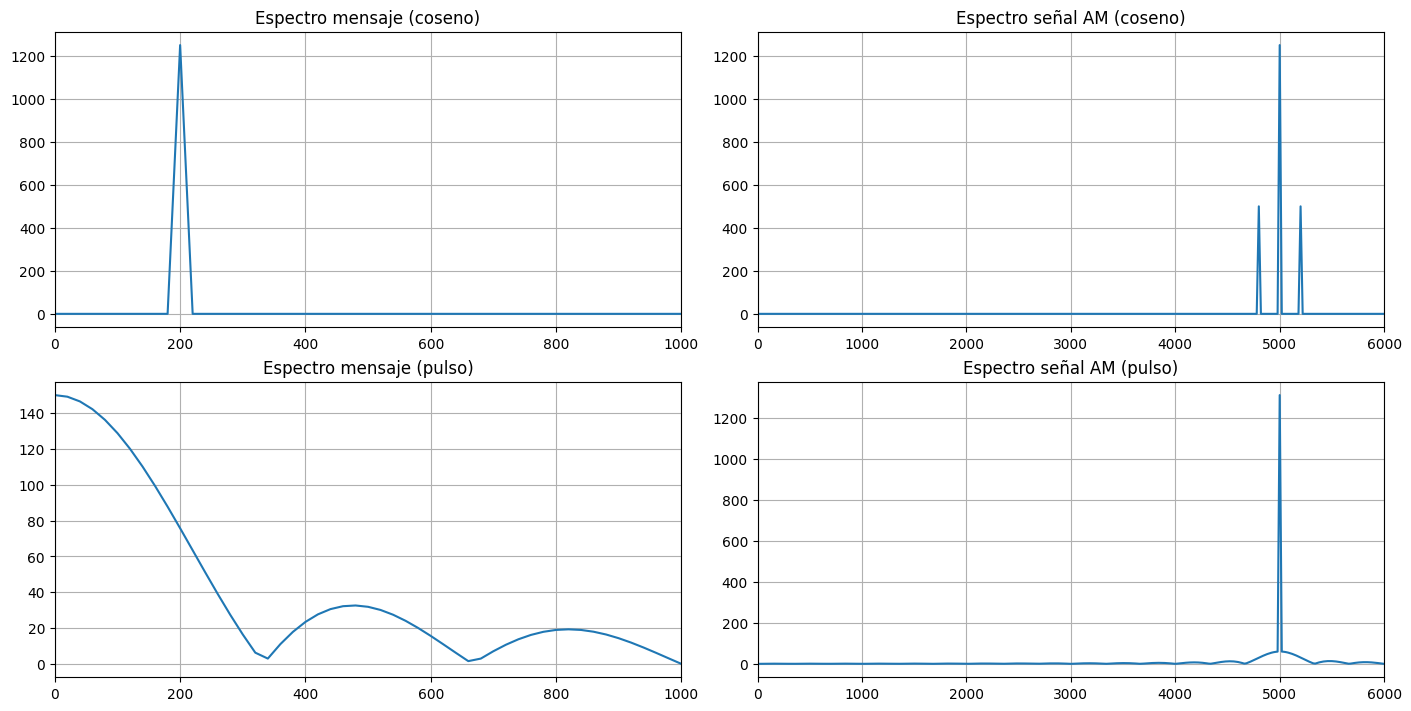

Parámetros: fs=50000 Hz, duración=0.05s, fc=5000Hz, índice de modulación m=0.8
Cutoff LP usado para detección: 1333.3 Hz


In [22]:
# ================================================================
# Taller 2 - Señales y Sistemas 2025
# Punto 1.5 - Modulación AM por detección coherente
# Autor: Yesid aza patiño
# Universidad Nacional de Colombia – Sede Manizales
# ================================================================

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq, irfft

# ------------------------------------------------------------
# Parámetros generales
# ------------------------------------------------------------
fs = 50000        # Frecuencia de muestreo (Hz)
T = 0.05          # Duración total (s)
t = np.arange(0, T, 1/fs)
fc = 5000         # Frecuencia de portadora (Hz)
m = 0.8           # Índice de modulación (0 < m <= 1)
Ac = 1.0          # Amplitud de la portadora

# ------------------------------------------------------------
# Señales mensaje
# ------------------------------------------------------------
fm = 200.0  # Frecuencia del mensaje coseno (Hz)

# Mensaje tipo coseno
msg_cos = np.cos(2*np.pi*fm*t)

# Mensaje tipo pulso rectangular (centro en T/2)
pulse_width = 0.003  # segundos
msg_rect = np.zeros_like(t)
center = T/2
msg_rect[np.abs(t-center) < (pulse_width/2)] = 1.0

# Normalización [-1, 1]
def normalize(x):
    maxv = np.max(np.abs(x))
    return x / maxv if maxv != 0 else x

msg_cos = normalize(msg_cos)
msg_rect = normalize(msg_rect)

# ------------------------------------------------------------
# Modulación AM: y(t) = Ac (1 + m * m(t)) cos(2πfct)
# ------------------------------------------------------------
def am_modulate(msg, m, Ac, fc, t):
    return Ac * (1 + m * msg) * np.cos(2*np.pi*fc*t)

s_cos = am_modulate(msg_cos, m, Ac, fc, t)
s_rect = am_modulate(msg_rect, m, Ac, fc, t)

# ------------------------------------------------------------
# Detección coherente: multiplicar por portadora y filtrar LP
# ------------------------------------------------------------
def coherent_detect(s, Ac, m, fc, fs, cutoff_hz, t):
    # Producto con la portadora local
    prod = s * np.cos(2*np.pi*fc*t)
    # FFT para filtrado ideal
    S = rfft(prod)
    freqs = rfftfreq(len(prod), 1/fs)
    H = np.zeros_like(S)
    H[freqs <= cutoff_hz] = 1.0
    S_filtered = S * H
    # Transformada inversa (tiempo)
    lp = irfft(S_filtered, n=len(prod))
    # Recuperar mensaje original
    recovered = (lp - 0.5*Ac) * (2.0 / (m*Ac))
    return prod, lp, recovered, freqs, np.abs(S)

# Corte del filtro LP (ligeramente mayor que la banda del mensaje)
cutoff = 4*max(fm, 1/pulse_width)
cutoff = min(cutoff, fs/2*0.9)

# Detección coherente
prod_cos, lp_cos, rec_cos, freqs_cos, S_cos = coherent_detect(s_cos, Ac, m, fc, fs, cutoff, t)
prod_rect, lp_rect, rec_rect, freqs_rect, S_rect = coherent_detect(s_rect, Ac, m, fc, fs, cutoff, t)

# ------------------------------------------------------------
# Gráficas
# ------------------------------------------------------------
plt.rcParams.update({'figure.max_open_warning': 0})
Nplot = int(0.002 * fs)  # 2 ms de visualización

fig, axs = plt.subplots(3, 2, figsize=(14, 9), constrained_layout=True)

# Mensajes
axs[0,0].plot(t[:Nplot], msg_cos[:Nplot])
axs[0,0].set_title("Mensaje: Coseno (tiempo)")
axs[0,0].set_xlabel("t [s]")
axs[0,0].grid(True)

axs[0,1].plot(t[:Nplot], msg_rect[:Nplot])
axs[0,1].set_title("Mensaje: Pulso rectangular (tiempo)")
axs[0,1].set_xlabel("t [s]")
axs[0,1].grid(True)

# Señales moduladas
axs[1,0].plot(t[:Nplot], s_cos[:Nplot])
axs[1,0].set_title(f"Señal AM (coseno) m={m}")
axs[1,0].grid(True)

axs[1,1].plot(t[:Nplot], s_rect[:Nplot])
axs[1,1].set_title(f"Señal AM (pulso) m={m}")
axs[1,1].grid(True)

# Detección coherente
axs[2,0].plot(t[:Nplot], prod_cos[:Nplot], label="producto")
axs[2,0].plot(t[:Nplot], lp_cos[:Nplot], label="LP ideal")
axs[2,0].plot(t[:Nplot], rec_cos[:Nplot], label="recuperada", linewidth=2)
axs[2,0].set_title("Detección coherente (coseno)")
axs[2,0].legend(); axs[2,0].grid(True)

axs[2,1].plot(t[:Nplot], prod_rect[:Nplot], label="producto")
axs[2,1].plot(t[:Nplot], lp_rect[:Nplot], label="LP ideal")
axs[2,1].plot(t[:Nplot], rec_rect[:Nplot], label="recuperada", linewidth=2)
axs[2,1].set_title("Detección coherente (pulso)")
axs[2,1].legend(); axs[2,1].grid(True)

plt.show()

# ------------------------------------------------------------
# Espectros de mensajes y moduladas
# ------------------------------------------------------------
fig2, axs2 = plt.subplots(2, 2, figsize=(14,7), constrained_layout=True)

# Espectros
f_msg = rfftfreq(len(msg_cos), 1/fs)
axs2[0,0].plot(f_msg, np.abs(rfft(msg_cos)))
axs2[0,0].set_xlim(0, 5*fm)
axs2[0,0].set_title("Espectro mensaje (coseno)")
axs2[0,0].grid(True)

axs2[0,1].plot(rfftfreq(len(s_cos), 1/fs), np.abs(rfft(s_cos)))
axs2[0,1].set_xlim(0, fc+5*fm)
axs2[0,1].set_title("Espectro señal AM (coseno)")
axs2[0,1].grid(True)

axs2[1,0].plot(rfftfreq(len(msg_rect), 1/fs), np.abs(rfft(msg_rect)))
axs2[1,0].set_xlim(0, 1/pulse_width*3)
axs2[1,0].set_title("Espectro mensaje (pulso)")
axs2[1,0].grid(True)

axs2[1,1].plot(rfftfreq(len(s_rect), 1/fs), np.abs(rfft(s_rect)))
axs2[1,1].set_xlim(0, fc+1/pulse_width*3)
axs2[1,1].set_title("Espectro señal AM (pulso)")
axs2[1,1].grid(True)

plt.show()

# ------------------------------------------------------------
# Resultados clave
# ------------------------------------------------------------
print(f"Parámetros: fs={fs} Hz, duración={T}s, fc={fc}Hz, índice de modulación m={m}")
print(f"Cutoff LP usado para detección: {cutoff:.1f} Hz")

# ================================================================
# Fin del script
# ================================================================
